In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval, plot_pies

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit

from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio, pretty_confusion_matrix

from utils import evaluate_metrics, evaluate_repair, plot_metrics

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

### Generate the problem / prepare selected datasets

In [3]:
nrows = None
random_seed = np.random.randint(0, 123123) #tri topora
print(random_seed)

52679


In [4]:
6094
15568

15568

In [5]:
def load_merged_dataset():
    """
    Function to load the adult income dataset
    
    Returns: X, y, protected_attribute
    """
    numerical_features_index = [0, 2, 4, 10, 11, 12]

    data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
    data_train.drop_duplicates(inplace=True)
    y_train = data_train.loc[:, data_train.columns[-1]]
    gender_train = data_train.loc[:, data_train.columns[9]]


    data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
    data_test.drop_duplicates(inplace=True)
    y_test = data_test.loc[:, data_test.columns[-1]]
    gender_test = data_test.loc[:, data_test.columns[9]]

    data = pd.concat((data_train, data_test))
    
    data.drop(data.columns.difference(numerical_features_index), axis=1, inplace=True)
    data = data.astype(np.float64)


    gender_train = gender_train.apply(lambda x: x.strip())
    gender_test = gender_test.apply(lambda x: x.strip())
    
#     y_train = y_train.loc[data_train.index]
#     gender_train = gender_train.loc[data_train.index]

    #assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]
    
    binarizer = LabelBinarizer()
    y_train = binarizer.fit_transform(y_train).ravel()
    y_test = binarizer.transform(y_test).ravel()

    gender_binarizer = LabelBinarizer()
    gender_binary_train = gender_binarizer.fit_transform(gender_train.values).ravel()
    gender_binary = gender_binarizer.transform(gender_test.values).ravel()

#     scaler = StandardScaler()
#     data = scaler.fit_transform(data)
    
    return data, np.concatenate((y_train, y_test)), np.concatenate((gender_binary_train, gender_binary))

In [6]:
# data, y_data, protected_attribute = load_merged_dataset()

In [7]:
# f, ax = plot_pies(data.values, protected_attribute, y_data, alpha=0.5)

In [8]:
# f.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/adult_income.png', frameon=True, transparent=True, bbox_inches='tight')

In [9]:
# shuffle_splitter = ShuffleSplit(n_splits=10, test_size=0.3, random_state=random_seed)

In [10]:
# for train_index, test_index in shuffle_splitter.split(data):
#     data_train, data_test = data.values[train_index], data.values[test_index]
#     y_train, y_test = y_data[train_index], y_data[test_index]
#     gender_train, gender_test = protected_attribute[train_index], protected_attribute[test_index]
#     break

In [11]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]
#gender_train = data_train.loc[:, data_train.columns[8]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
#gender_test = data_test.loc[:, data_test.columns[8]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)


gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

# gender_train = gender_train.apply(lambda x: 1 if x.strip() == 'White' else 0)
# gender_test = gender_test.apply(lambda x: 1 if x.strip() == 'White' else 0)

In [13]:
data_train.drop_duplicates(inplace=True)
data_test.drop_duplicates(inplace=True)

y_train = y_train.loc[data_train.index]
y_test = y_test.loc[data_test.index]
gender_train = gender_train.loc[data_train.index]
gender_test = gender_test.loc[data_test.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

y_def_train = y_train
y_def_test = y_test

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

gender_binarizer = LabelBinarizer()
gender_train = gender_binarizer.fit_transform(gender_train.values).ravel()
gender_test = gender_binarizer.fit_transform(gender_test.values).ravel()

scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

from sklearn.model_selection import GridSearchCV

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
clf_base = RandomForestClassifier(class_weight='balanced')#random_state=random_seed)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 500, 1000],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}
CLF_NAME = 'RF'

In [17]:
# clf_base = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200],
#     'min_samples_split': [2, 3, 4, 5],
#     'min_samples_leaf': [1, 2, 3],
#     'max_depth':[2, 3, 4]
# }
# CLF_NAME = 'GB'

In [18]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.1, 0.2, 0.5, 1],
# }
# CLF_NAME = 'LR'

In [19]:
data_train.shape

(32334, 6)

In [20]:
data_test.shape

(16226, 6)

In [21]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500, 1000], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [22]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
from utils import di_acc_curve

In [24]:
acc_curve, di_curve = di_acc_curve(clf, data_test, y_test, gender_test)

In [25]:
list(enumerate(di_curve))

[(0, 0.7643224030221297),
 (1, 0.7597076319806735),
 (2, 0.755034347364181),
 (3, 0.746165379336603),
 (4, 0.7436080421980367),
 (5, 0.7380227503216222),
 (6, 0.7331908296438833),
 (7, 0.7286795953405995),
 (8, 0.7285283778387585),
 (9, 0.722534912957269),
 (10, 0.7173126380547926),
 (11, 0.7152106613589609),
 (12, 0.7168699184407806),
 (13, 0.7106164771927261),
 (14, 0.7066774607715833),
 (15, 0.7050023061902696),
 (16, 0.6998244001421621),
 (17, 0.6972650854883057),
 (18, 0.6872135273477108),
 (19, 0.6820400507517633),
 (20, 0.6798580641656954),
 (21, 0.6756615346897956),
 (22, 0.6690622161984602),
 (23, 0.6637142153062402),
 (24, 0.660160562875666),
 (25, 0.6539731197018399),
 (26, 0.6502876338093623),
 (27, 0.6492614024116633),
 (28, 0.6462547458515807),
 (29, 0.6476792375725144),
 (30, 0.6414500789377506),
 (31, 0.6384010121749147),
 (32, 0.6344675310462313),
 (33, 0.6311327994690166),
 (34, 0.6269959976050389),
 (35, 0.6228043852891213),
 (36, 0.623832142111578),
 (37, 0.62274635

In [26]:
clf_predictions = clf.predict(data_test)

In [27]:
print(Counter(y_test))

print(Counter(clf_predictions))

Counter({0: 12390, 1: 3836})
Counter({0: 12932, 1: 3294})


In [28]:
accuracy_before = accuracy_score(y_test, clf_predictions)
di_before = disparate_impact(clf_predictions, gender_test)
print('Initial accuracy of classification: {}'.format(accuracy_before))
print('Initial DI: {}'.format(di_before))

Initial accuracy of classification: 0.8091951189449033
Initial DI: 0.5777317874325665


In [29]:
negative_label = 0
positive_label = 1

In [30]:
male_entries_index = gender_train[gender_train == positive_label]
female_entries_index = gender_train[gender_train == negative_label]

male_entries_test_index = gender_test[gender_test == positive_label]
female_entries_test_index = gender_test[gender_test == negative_label]

In [31]:
n0 = data_train[gender_train == positive_label].shape[0]
n1 = data_train[gender_train == negative_label].shape[0]
n0_test = data_test[gender_test == positive_label].shape[0]
n1_test = data_test[gender_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [32]:
C = ot.dist(data_test[gender_test == positive_label], data_test[gender_test == negative_label])

In [33]:
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G

In [33]:
#coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=0.005, reg2=1e-3, f=f, df=df, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.005, method='SAG', numItermax=100000, log=True)[0]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.4 µs


In [89]:
%%time
coupling1 = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.001, stopThr=1e-9, verbose=True)

It.  |Err         
-------------------
    0|6.708180e-05|
   10|6.662534e-06|
   20|3.777412e-06|
   30|3.353400e-06|
   40|3.250827e-06|
   50|3.172667e-06|
   60|3.077192e-06|
   70|2.940049e-06|
   80|2.691442e-06|
   90|2.306028e-06|
  100|1.890490e-06|
  110|1.626111e-06|
  120|1.450069e-06|
  130|1.327713e-06|
  140|1.251144e-06|
  150|1.205696e-06|
  160|1.176436e-06|
  170|1.156871e-06|
  180|1.144398e-06|
  190|1.137241e-06|
It.  |Err         
-------------------
  200|1.133582e-06|
  210|1.131879e-06|
  220|1.131135e-06|
  230|1.130817e-06|
  240|1.108912e-06|
  250|1.001368e-06|
  260|9.614101e-07|
  270|9.595603e-07|
  280|9.354366e-07|
  290|7.128209e-07|
  300|4.781924e-07|
  310|4.390841e-07|
  320|4.104033e-07|
  330|3.309969e-07|
  340|2.807180e-07|
  350|2.456212e-07|
  360|2.334714e-07|
  370|2.327714e-07|
  380|2.327521e-07|
  390|2.327511e-07|
It.  |Err         
-------------------
  400|2.327509e-07|
  410|2.327508e-07|
  420|2.327507e-07|
  430|2.327506e-07|
  4

In [101]:
coupling2 = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, verbose=1, m=1)

It.  |Err         
-------------------
    0|5.815473e-08|
    1|4.070536e-08|
    2|3.184841e-08|
    3|2.649000e-08|
    4|2.289979e-08|
    5|2.040109e-08|
    6|1.848217e-08|
    7|1.686435e-08|
    8|1.553417e-08|
    9|1.442332e-08|
   10|1.349746e-08|
   11|1.265904e-08|
   12|1.194079e-08|
   13|1.127699e-08|
   14|1.067578e-08|
   15|1.013270e-08|
   16|9.624254e-09|
   17|9.146737e-09|
   18|8.707022e-09|
   19|8.294461e-09|
It.  |Err         
-------------------
   20|7.907693e-09|
   21|7.557208e-09|
   22|7.218351e-09|
   23|6.901547e-09|
   24|6.605341e-09|
   25|6.320394e-09|
   26|6.047919e-09|
   27|5.787400e-09|
   28|5.541250e-09|
   29|5.311012e-09|
   30|5.097074e-09|
   31|4.896342e-09|
   32|4.709800e-09|
   33|4.533915e-09|
   34|4.367839e-09|
   35|4.211956e-09|
   36|4.067137e-09|
   37|3.932484e-09|
   38|3.804145e-09|
   39|3.681889e-09|
It.  |Err         
-------------------
   40|3.567262e-09|
   41|3.458983e-09|
   42|3.357872e-09|
   43|3.261333e-09|
   

In [36]:
# ot_mapping_linear = ot.da.MappingTransport(kernel='linear', mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True)

# ot_mapping_linear.fit(Xs = data_train[gender_train == positive_label], Xt=data_train[gender_train == negative_label])

In [ ]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

In [68]:
num = 100

In [69]:
y_first = y_test[gender_test == positive_label]
y_second = y_test[gender_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (10819,)
class 1 size (5407,)


In [70]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [71]:
from collections import defaultdict
from tqdm import tqdm

In [72]:
pretty_confusion_matrix(y_train, gender_train)

,Y = 0,Y = 1
C = 0,9546.0,1174.0
C = 1,14987.0,6627.0


In [73]:
gender_test_new = np.concatenate((np.ones(y_first.shape[0]), np.zeros(y_second.shape[0])))

In [74]:
pretty_confusion_matrix(y_test, gender_test)

,Y = 0,Y = 1
C = 0,4818.0,589.0
C = 1,7572.0,3247.0


In [75]:
couplings = {}

In [76]:
# for rv in tqdm(np.linspace(0.01, 1, num=100)):
#     coupling = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, verbose=False, log=False, m=rv)
#     couplings[rv] = coupling

In [77]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

partial_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling2, y0, y1)
random_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling2, y0, y1, theta=rv)

In [79]:
evaluation_1 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [80]:
evaluation_2 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair full ot')#

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [90]:
evaluation_3 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [91]:
evaluation_4 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair regularized ot')

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [102]:
evaluation_5 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, partial_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, name='partial repair regularized ot')

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [103]:
evaluation_6 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test_new, random_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair partial regularized ot')

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


In [93]:
XX, yy = partial_repair_reg_func_pt(1, data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second)
disparate_impact(clf.predict(XX), gender_test_new)

0.98630487732534

In [94]:
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_1['Accuracy'][-1], evaluation_1['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_3['Accuracy'][-1], evaluation_3['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_5['Accuracy'][-1], evaluation_5['DI'][-1]))

RF & 0.809 & 0.578 & 0.785 & 0.902
RF & 0.809 & 0.578 & 0.784 & 1.059
RF & 0.809 & 0.578 & 0.778 & 0.986


In [95]:
#evaluation_1['DI'][0]

In [96]:
#evaluation_1['CI_target']

In [ ]:
np.linspace(0.005, 0.1, num=20)

In [ ]:
dis_t = []
ls = np.linspace(0.005, 1, num=20)
for rv in tqdm(ls):
    coupling_t = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=rv, verbose=False, log=False, m=1)
    XX, yy = partial_repair(1, data_test[gender_test == positive_label], data_test[gender_test == negative_label], coupling_t, y_first, y_second)
    dis_t.append(disparate_impact(clf.predict(XX), gender_test_new))
    
plt.plot(ls, dis_t)

In [79]:
list(zip(ls, dis_t))

[(0.005, 0.7340075632462293),
 (0.01, 0.9141604983718302),
 (0.015, 0.6889411485887112),
 (0.02, 0.6628450334705441),
 (0.025, 0.5784986456206305),
 (0.030000000000000002, 0.5995550626644561),
 (0.034999999999999996, 0.569658285325402),
 (0.04, 0.6449867252530465),
 (0.045, 0.6376573306478984),
 (0.049999999999999996, 0.6571302609641594),
 (0.055, 0.6083397522273054),
 (0.06, 0.5685284280251718),
 (0.065, 0.5770457078457735),
 (0.07, 0.5867373260226578),
 (0.07500000000000001, 0.5599602781358605),
 (0.08, 0.63970084215491),
 (0.085, 0.644492608762812),
 (0.09000000000000001, 0.646915513307033),
 (0.095, 0.7269277098836368),
 (0.1, 0.7269277098836368)]

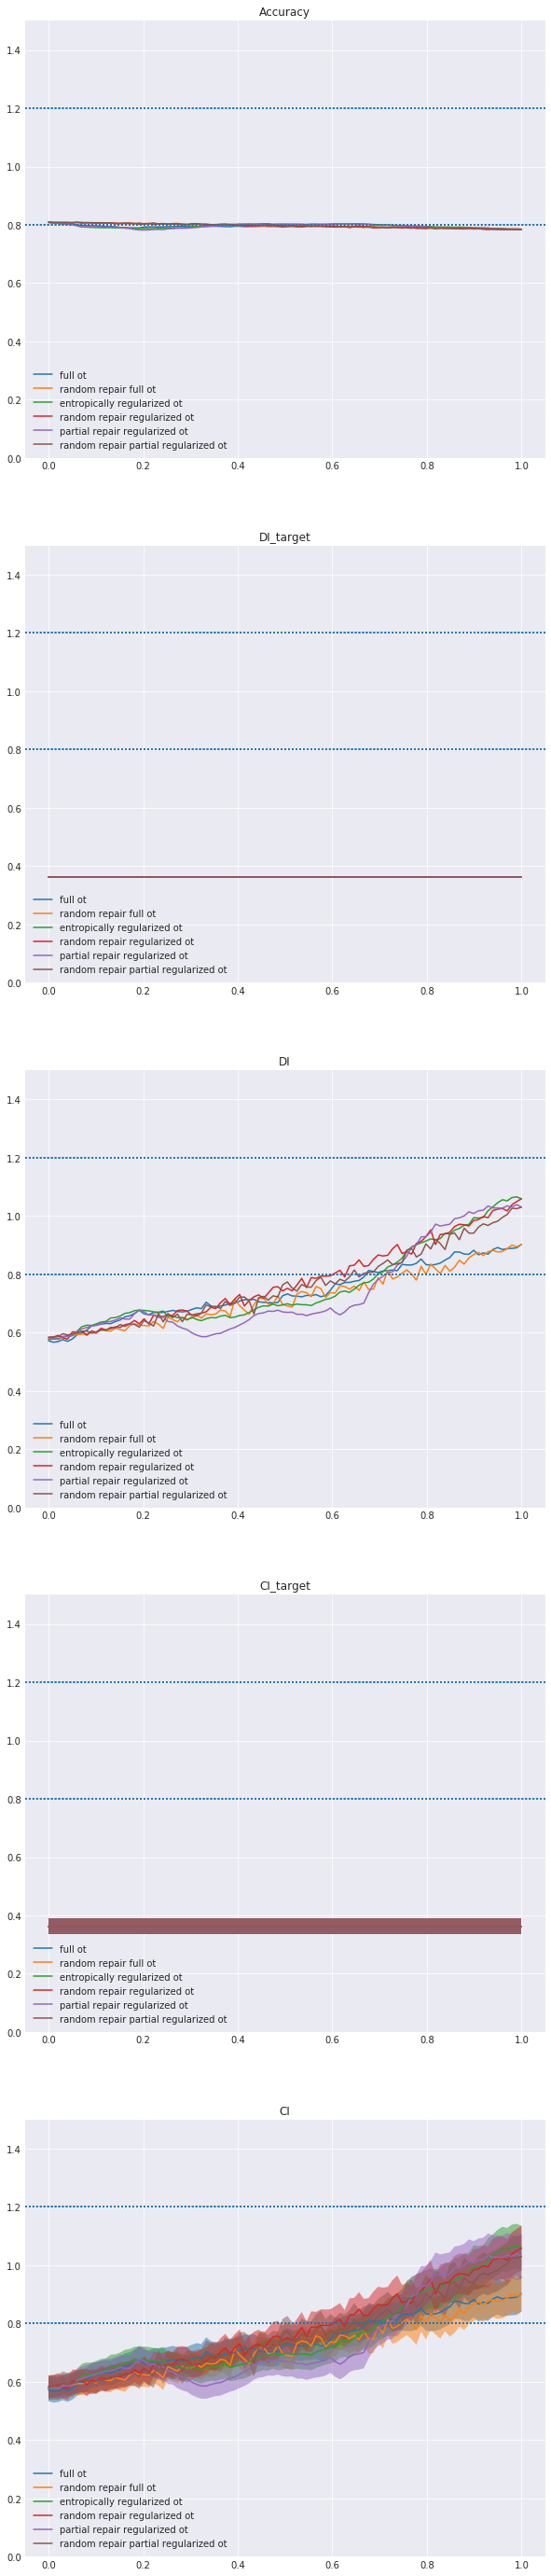

In [104]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6])

Text(0.5,0,'Amount of repair')

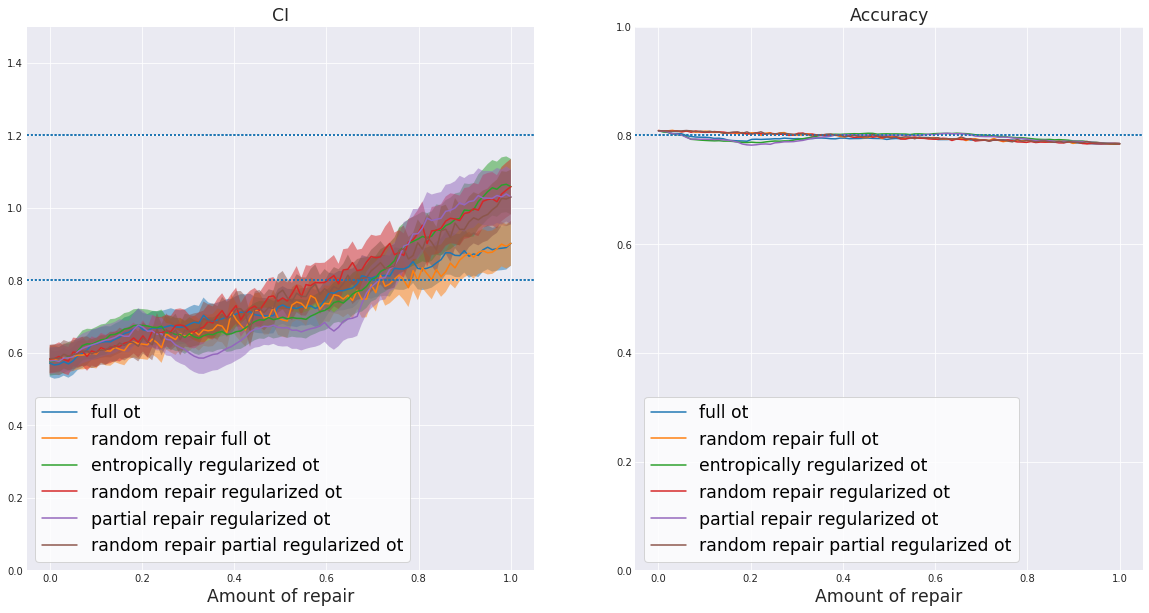

In [113]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6], what_to_plot=['CI', 'Accuracy'], subplot_shape=(1, 2), subplot_size=(20, 10))
aaaa[1].set_ylim(0, 1)
aaaa[0].legend(fontsize='xx-large', loc='best')
aaaa[0].set_title('CI', fontsize='xx-large')
aaaa[0].set_xlabel('Amount of repair', fontsize='xx-large')
aaaa[1].legend(fontsize='xx-large', loc='best')
aaaa[1].set_title('Accuracy', fontsize='xx-large')
aaaa[1].set_xlabel('Amount of repair', fontsize='xx-large')

In [114]:
fig.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/SkoltechLaTeXtemplates/presentation_beamer/img/adult_income_tradeoff_rf_1.pgf', frameon=True, bbox_inches='tight')

In [93]:
with open('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/adult_income_tradeoff_gb.pickle', mode='wb') as file:
    pl.dump(fig, file)